
**Install requirements**

In [ ]:

!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'


**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 7e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 40      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 250       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [ ]:
#!rm -r aiml2020
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'

# Clone github repository with data
if not os.path.isdir('./aiml2020'):
  !git clone https://github.com/GianlucaMega/aiml2020.git

from aiml2020.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)


test dataset length: 2893 Number of classes: 101
train dataset length: 5784 Number of classes: 101


In [ ]:
len(train_dataset)

3842

In [ ]:
train_indexes = [ i for i in range(len(train_dataset)-20) if i%3!=0]# split the indices for your train split
val_indexes =  [ i for i in range(0,len(train_dataset)-20,3)] # split the indices for your val split

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

In [ ]:
len(train_dataset)

3856

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [ ]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0

losses = [0 for i in range(NUM_EPOCHS)]

accuracy = [0 for i in range(NUM_EPOCHS)]

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  tot_epoch_losses = 0
  tot_epoch_steps = 0
  running_corrects = 0

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    tot_epoch_losses += loss.item()
    tot_epoch_steps += 1

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Calculate Accuracy
  accuracy[epoch] = running_corrects / float(tot_epoch_steps)
  losses[epoch] = tot_epoch_losses/tot_epoch_steps

  # Step the scheduler
  scheduler.step() 



Starting epoch 1/40, LR = [0.007]
Step 0, Loss 4.625086307525635
Step 10, Loss 4.619933128356934
Starting epoch 2/40, LR = [0.007]
Step 20, Loss 4.60659122467041
Starting epoch 3/40, LR = [0.007]
Step 30, Loss 4.581700801849365
Step 40, Loss 4.558681488037109
Starting epoch 4/40, LR = [0.007]
Step 50, Loss 4.501858711242676
Starting epoch 5/40, LR = [0.007]
Step 60, Loss 4.4040374755859375
Step 70, Loss 4.273036479949951
Starting epoch 6/40, LR = [0.007]
Step 80, Loss 4.092861652374268
Starting epoch 7/40, LR = [0.007]
Step 90, Loss 4.200665473937988
Step 100, Loss 4.1952033042907715
Starting epoch 8/40, LR = [0.007]
Step 110, Loss 4.173742294311523
Starting epoch 9/40, LR = [0.007]
Step 120, Loss 4.117091178894043
Step 130, Loss 4.004977703094482
Starting epoch 10/40, LR = [0.007]
Step 140, Loss 3.908478260040283
Starting epoch 11/40, LR = [0.007]
Step 150, Loss 3.8948094844818115
Step 160, Loss 3.930647611618042
Starting epoch 12/40, LR = [0.007]
Step 170, Loss 3.6754326820373535
Sta

		LOSS


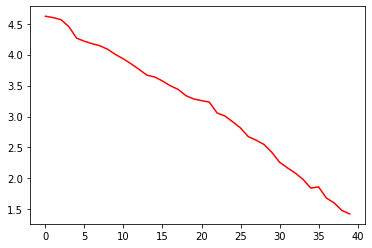

		ACCURACY


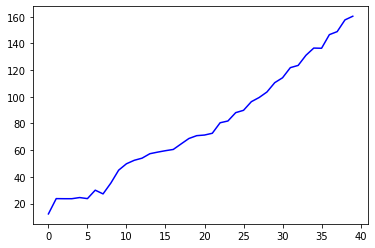

In [ ]:
print("\t\tLOSS")
plt.figure()
plt.plot(range(NUM_EPOCHS), losses, color='red')
plt.show()
print("\t\tACCURACY")
plt.figure()
plt.plot(range(NUM_EPOCHS), accuracy, color='blue')
plt.show()

**Validation**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)
  
  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))




  0%|          | 0/8 [00:00<?, ?it/s]


 12%|█▎        | 1/8 [00:02<00:15,  2.27s/it]


 25%|██▌       | 2/8 [00:02<00:10,  1.68s/it]


 38%|███▊      | 3/8 [00:02<00:06,  1.26s/it]


 50%|█████     | 4/8 [00:03<00:03,  1.05it/s]


 62%|██████▎   | 5/8 [00:03<00:02,  1.38it/s]


 75%|███████▌  | 6/8 [00:03<00:01,  1.83it/s]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

Validation Accuracy: 0.5187304890738814


**Test**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))




  0%|          | 0/12 [00:00<?, ?it/s]


  8%|▊         | 1/12 [00:02<00:26,  2.39s/it]


 17%|█▋        | 2/12 [00:02<00:17,  1.75s/it]


 25%|██▌       | 3/12 [00:02<00:11,  1.30s/it]


 33%|███▎      | 4/12 [00:03<00:07,  1.01it/s]


 42%|████▏     | 5/12 [00:03<00:06,  1.07it/s]


 50%|█████     | 6/12 [00:04<00:04,  1.38it/s]


 58%|█████▊    | 7/12 [00:04<00:02,  1.76it/s]


 67%|██████▋   | 8/12 [00:04<00:01,  2.17it/s]


 75%|███████▌  | 9/12 [00:04<00:01,  2.60it/s]


 83%|████████▎ | 10/12 [00:04<00:00,  3.24it/s]


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]

Test Accuracy: 0.5008641548565503
